In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlopen
import json
from sodapy import Socrata
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from country_list import countries_for_language
import unidecode
plt.style.use('https://raw.githubusercontent.com/datatrooper/instatrooper/master/styles/w2dt.mplstyle')
dp = [
    "#1c1c3c",
    "#967B4F",
    "#46493D",
    "#839DA5",
    "#9FADAD",
    "#2B4144",
    "#986E37"
]
plt.rcParams['axes.grid'] = False

In [2]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [3]:
def load_muestras_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("8835-5baf", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [4]:
df_boletines = pd.read_csv("May29.csv")
df_boletines = df_boletines[df_boletines["Departamento"] == "Antioquia" ]
df_boletines.head()

FileNotFoundError: [Errno 2] File b'May29.csv' does not exist: b'May29.csv'

In [5]:
df_col = load_colombia_df()

In [6]:
df_muestras = load_muestras_df()
df_muestras

,fecha,acumuladas,amazonas,antioquia,arauca,atlantico,bogota,bolivar,boyaca,caldas,...,quindio,risaralda,san_andres,santander,sucre,tolima,valle_del_cauca,vaupes,vichada,procedencia_desconocida
0,Acumulado Feb,601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-05T00:00:00.000,636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-06T00:00:00.000,739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-07T00:00:00.000,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-08T00:00:00.000,813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2020-06-01T00:00:00.001,341142,6770,42768,1204,22927,103149,21383,7878,4889,...,2340,6228,575,9086,2131,5567,30695,636,296,3635
90,2020-06-02T00:00:00.001,350123,6876,44128,1232,24050,105540,21596,8117,4963,...,2446,6384,575,9646,2286,5687,31325,636,296,3673
91,2020-06-03T00:00:00.001,362432,7080,44900,1261,25567,109606,22864,8435,5026,...,2505,6574,581,9999,2404,5786,32182,636,296,3739
92,2020-06-04T00:00:00.001,374592,7190,45759,1337,27344,113356,24515,8691,5066,...,2544,6678,592,10208,2652,5804,32936,788,446,3830


In [7]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [8]:
df_col = preprocess_df(df_col)

In [9]:
df_ant = df_col[df_col["departamento"] == "Antioquia"]

In [10]:
df_ant

,id_de_caso,Fecha de notificacion,codigo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,fecha_de_muerte,tiempo recuperacion,tiempo muerte
2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,50,F,IMPORTADO,LEVE,España,2020-02-29,2020-03-09,2020-03-15,2020-03-09T00:00:00.000,PCR,NaT,15.0,NaN
3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,55,M,RELACIONADO,LEVE,Colombia,2020-03-06,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,PCR,NaT,20.0,NaN
4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,25,M,RELACIONADO,LEVE,Colombia,2020-03-08,2020-03-11,2020-03-23,2020-03-11T00:00:00.000,PCR,NaT,15.0,NaN
5,6,2020-03-10T00:00:00.000,5360,Itagüí,Antioquia,RECUPERADO,27,F,RELACIONADO,LEVE,Colombia,2020-03-06,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,PCR,NaT,20.0,NaN
19,20,2020-03-11T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,26,F,RELACIONADO,LEVE,Colombia,2020-03-09,2020-03-14,2020-03-24,2020-03-14T00:00:00.000,PCR,NaT,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36026,36067,2020-06-04T00:00:00.000,5001,Medellín,Antioquia,CASA,36,F,EN ESTUDIO,ASINTOMATICO,Colombia,NaT,2020-06-05,NaT,2020-06-05T00:00:00.000,NaN,NaT,NaN,NaN
36027,36068,2020-06-02T00:00:00.000,5001,Medellín,Antioquia,CASA,37,F,EN ESTUDIO,LEVE,Colombia,2020-05-28,2020-06-05,NaT,2020-06-05T00:00:00.000,NaN,NaT,NaN,NaN
36028,36069,2020-06-05T00:00:00.000,5042,Santa Fé de Antioquia,Antioquia,CASA,25,F,EN ESTUDIO,ASINTOMATICO,Colombia,NaT,2020-06-05,NaT,2020-06-05T00:00:00.000,NaN,NaT,NaN,NaN
36029,36070,2020-06-05T00:00:00.000,5154,Caucasia,Antioquia,HOSPITAL UCI,64,M,EN ESTUDIO,ASINTOMATICO,Colombia,NaT,2020-06-05,NaT,2020-06-05T00:00:00.000,NaN,NaT,NaN,NaN


## Generales

In [11]:
ultimo_dia = df_ant[df_ant["Fecha de diagnóstico"] == "2020-05-30"]
nuevos_inf = ultimo_dia.shape[0]
nuevos_muertos = df_ant[df_ant["fecha_de_muerte"] == "2020-05-30"].shape[0]
nuevos_recuperados = df_ant[df_ant["fecha_recuperado"] == "2020-05-30"].shape[0]

infectados_totales = df_ant.shape[0]

recuperados_totales = df_ant["atencion"].value_counts()["RECUPERADO"]
fallecidos_totales = df_ant["atencion"].value_counts()["FALLECIDO"]
uci = df_ant["atencion"].value_counts()["HOSPITAL UCI"]
hospital = df_ant["atencion"].value_counts()["HOSPITAL"]
activos_totales = df_ant[df_ant["atencion"].isin(["CASA", "HOSPITAL", "HOSPITAL UCI"])].shape[0]

print(f"""
nuevos infectados: {nuevos_inf}
nuevos muertos: {nuevos_muertos}
nuevos recuperados: {nuevos_recuperados}
infectados totales: {infectados_totales}
recuperados totales: {recuperados_totales}
fallecidos totales: {fallecidos_totales}
uci: {uci}
hospital: {hospital}
activos totales: {activos_totales}
""")


nuevos infectados: 35
nuevos muertos: 0
nuevos recuperados: 7
infectados totales: 1360
recuperados totales: 552
fallecidos totales: 6
uci: 8
hospital: 18
activos totales: 801



In [12]:
last_date = df_boletines["fecha_boletin"].max()
df_boletines[df_boletines["fecha_boletin"] == last_date]

NameError: name 'df_boletines' is not defined

## Infectados

In [13]:
cuenta = pd.DataFrame(df_ant.groupby("Fecha de diagnóstico")["id_de_caso"].count()).reset_index()
cuenta = cuenta.rename(columns={"id_de_caso":"cuenta"})
idx = pd.date_range(cuenta["Fecha de diagnóstico"].min(), cuenta["Fecha de diagnóstico"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta = all_dates.merge(cuenta, left_on="fecha", 
                right_on="Fecha de diagnóstico", 
                how="left").drop("Fecha de diagnóstico", axis=1).fillna(0)
cuenta["fecha"] = cuenta["fecha"].dt.strftime('%m-%d')

In [14]:
cuenta["cuenta"].sum()

1360.0

In [15]:
cuenta[cuenta["fecha"] == "05-11"].index[0]

63

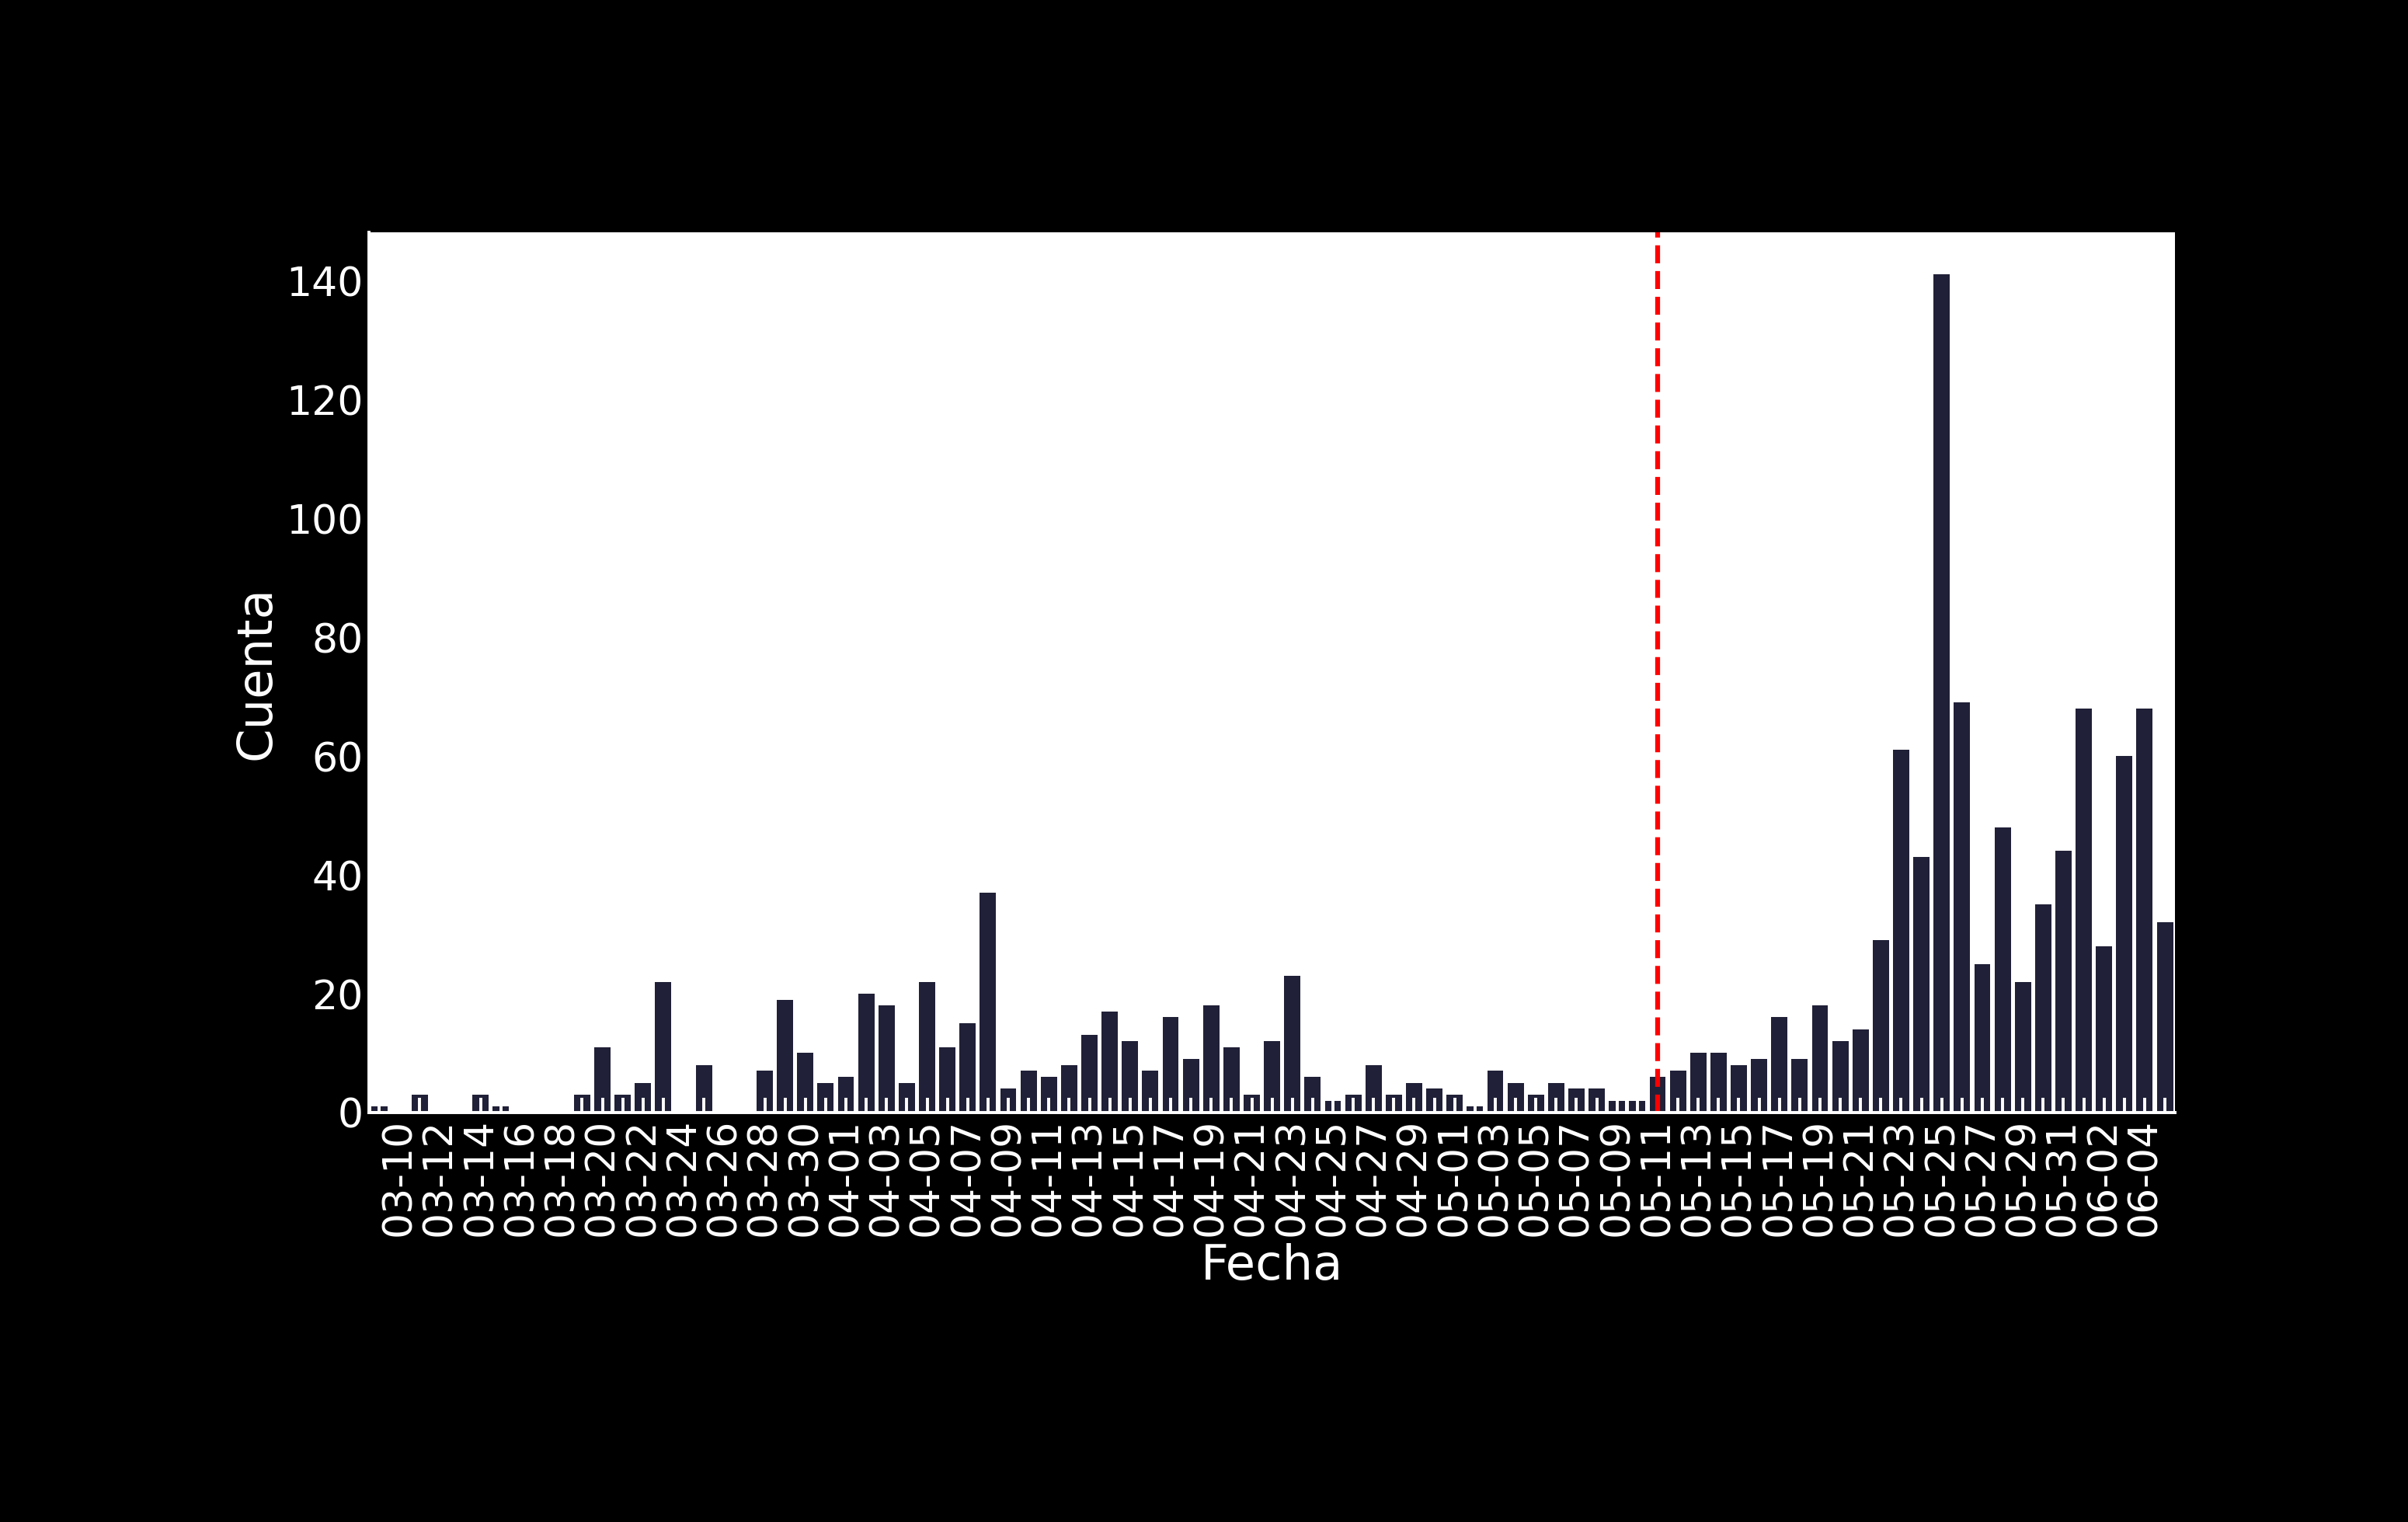

In [16]:
sns.set_context("talk")
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta, color="#1c1c3c")
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)

plt.axvline(cuenta[cuenta["fecha"] == "05-11"].index[0], color="red", linestyle='--', linewidth=3)

ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("Cuenta", fontsize=30)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f'confirmados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Activos

In [17]:
activos = ['casa', 'hospital UCI', 'hospital', 'En casa',
       'Hospital UCI', 'Hospital', 'Casa',
       'Casa  ', 'Hospital UCI ']
df_activos = df_boletines[df_boletines["Ubicación"].isin(activos)]
df_activos.head()

,fecha_boletin,Caso,Departamento,Ciudad,Edad,Sexo,Ubicación,Estado,Código ciudad
2,2020-03-28,3.0,Antioquia,Medellín,50,F,casa,NaN,NaN
3,2020-03-28,4.0,Antioquia,Medellín,55,M,casa,NaN,NaN
4,2020-03-28,5.0,Antioquia,Medellín,25,M,casa,NaN,NaN
5,2020-03-28,6.0,Antioquia,Itagui,27,F,casa,NaN,NaN
19,2020-03-28,20.0,Antioquia,Medellín,26,F,casa,NaN,NaN


In [18]:
cuenta = df_activos.groupby("fecha_boletin").size().to_frame("cuenta").reset_index()
cuenta["fecha_boletin"] = pd.to_datetime(cuenta["fecha_boletin"])
cuenta["fecha_boletin"] = cuenta["fecha_boletin"].dt.strftime('%m-%d')
cuenta.tail()



,fecha_boletin,cuenta
53,05-25,459
54,05-26,522
55,05-27,549
56,05-28,590
57,05-29,569


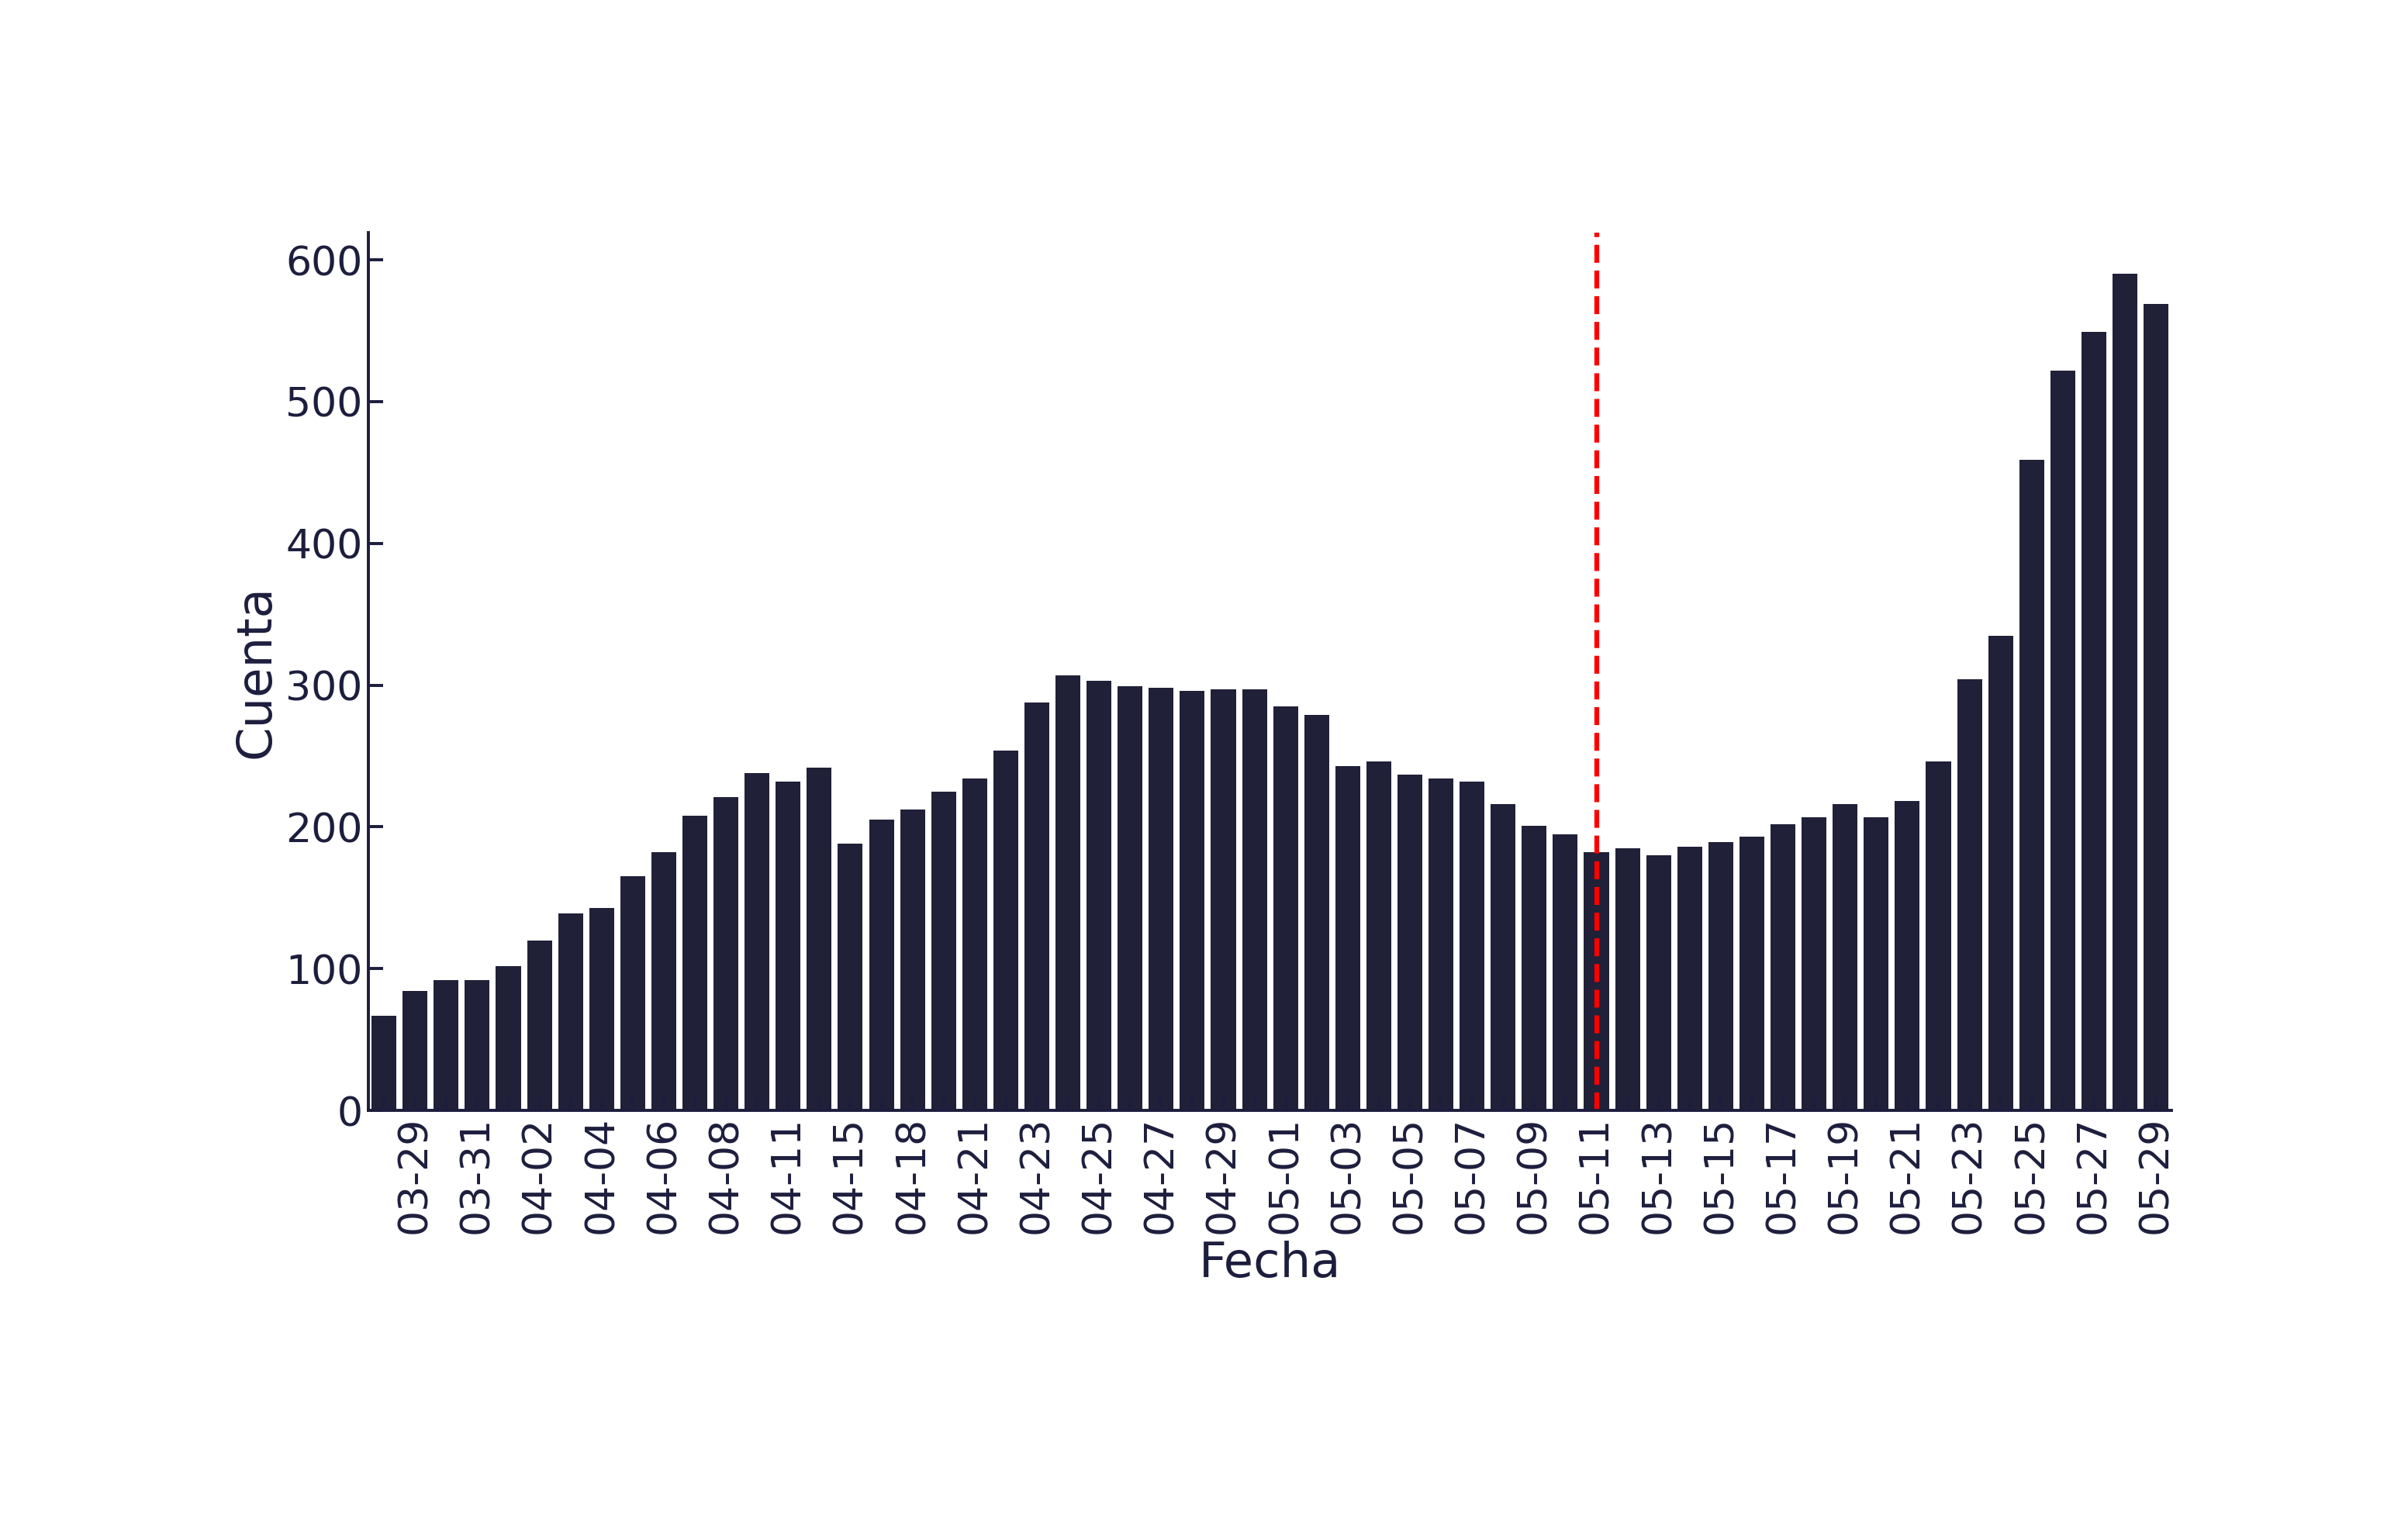

In [19]:
sns.set_context("talk")
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha_boletin", y="cuenta", data=cuenta, color="#1c1c3c")
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)

plt.axvline(cuenta[cuenta["fecha_boletin"] == "05-11"].index[0], color="red", linestyle='--', linewidth=3)

ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("Cuenta", fontsize=30)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f'activos_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Numero de pruebas 

### Antioquia

In [20]:
df_muestras_ant = df_muestras.loc[:,["fecha", "antioquia"]]
df_muestras_ant = df_muestras_ant[df_muestras_ant["antioquia"].notnull()]
df_muestras_ant["fecha"] = pd.to_datetime(df_muestras_ant["fecha"])
df_muestras_ant["fecha"] = df_muestras_ant["fecha"].dt.strftime('%m-%d')
df_muestras_ant["antioquia"] = df_muestras_ant["antioquia"].astype(int)
df_muestras_ant["cuenta"] = df_muestras_ant["antioquia"].diff()
df_muestras_ant

,fecha,antioquia,cuenta
67,05-10,21161,NaN
68,05-11,21676,515.0
69,05-12,22573,897.0
70,05-13,23234,661.0
71,05-14,23733,499.0
72,05-15,24478,745.0
73,05-16,25322,844.0
74,05-17,26154,832.0
75,05-18,26483,329.0
76,05-19,27349,866.0


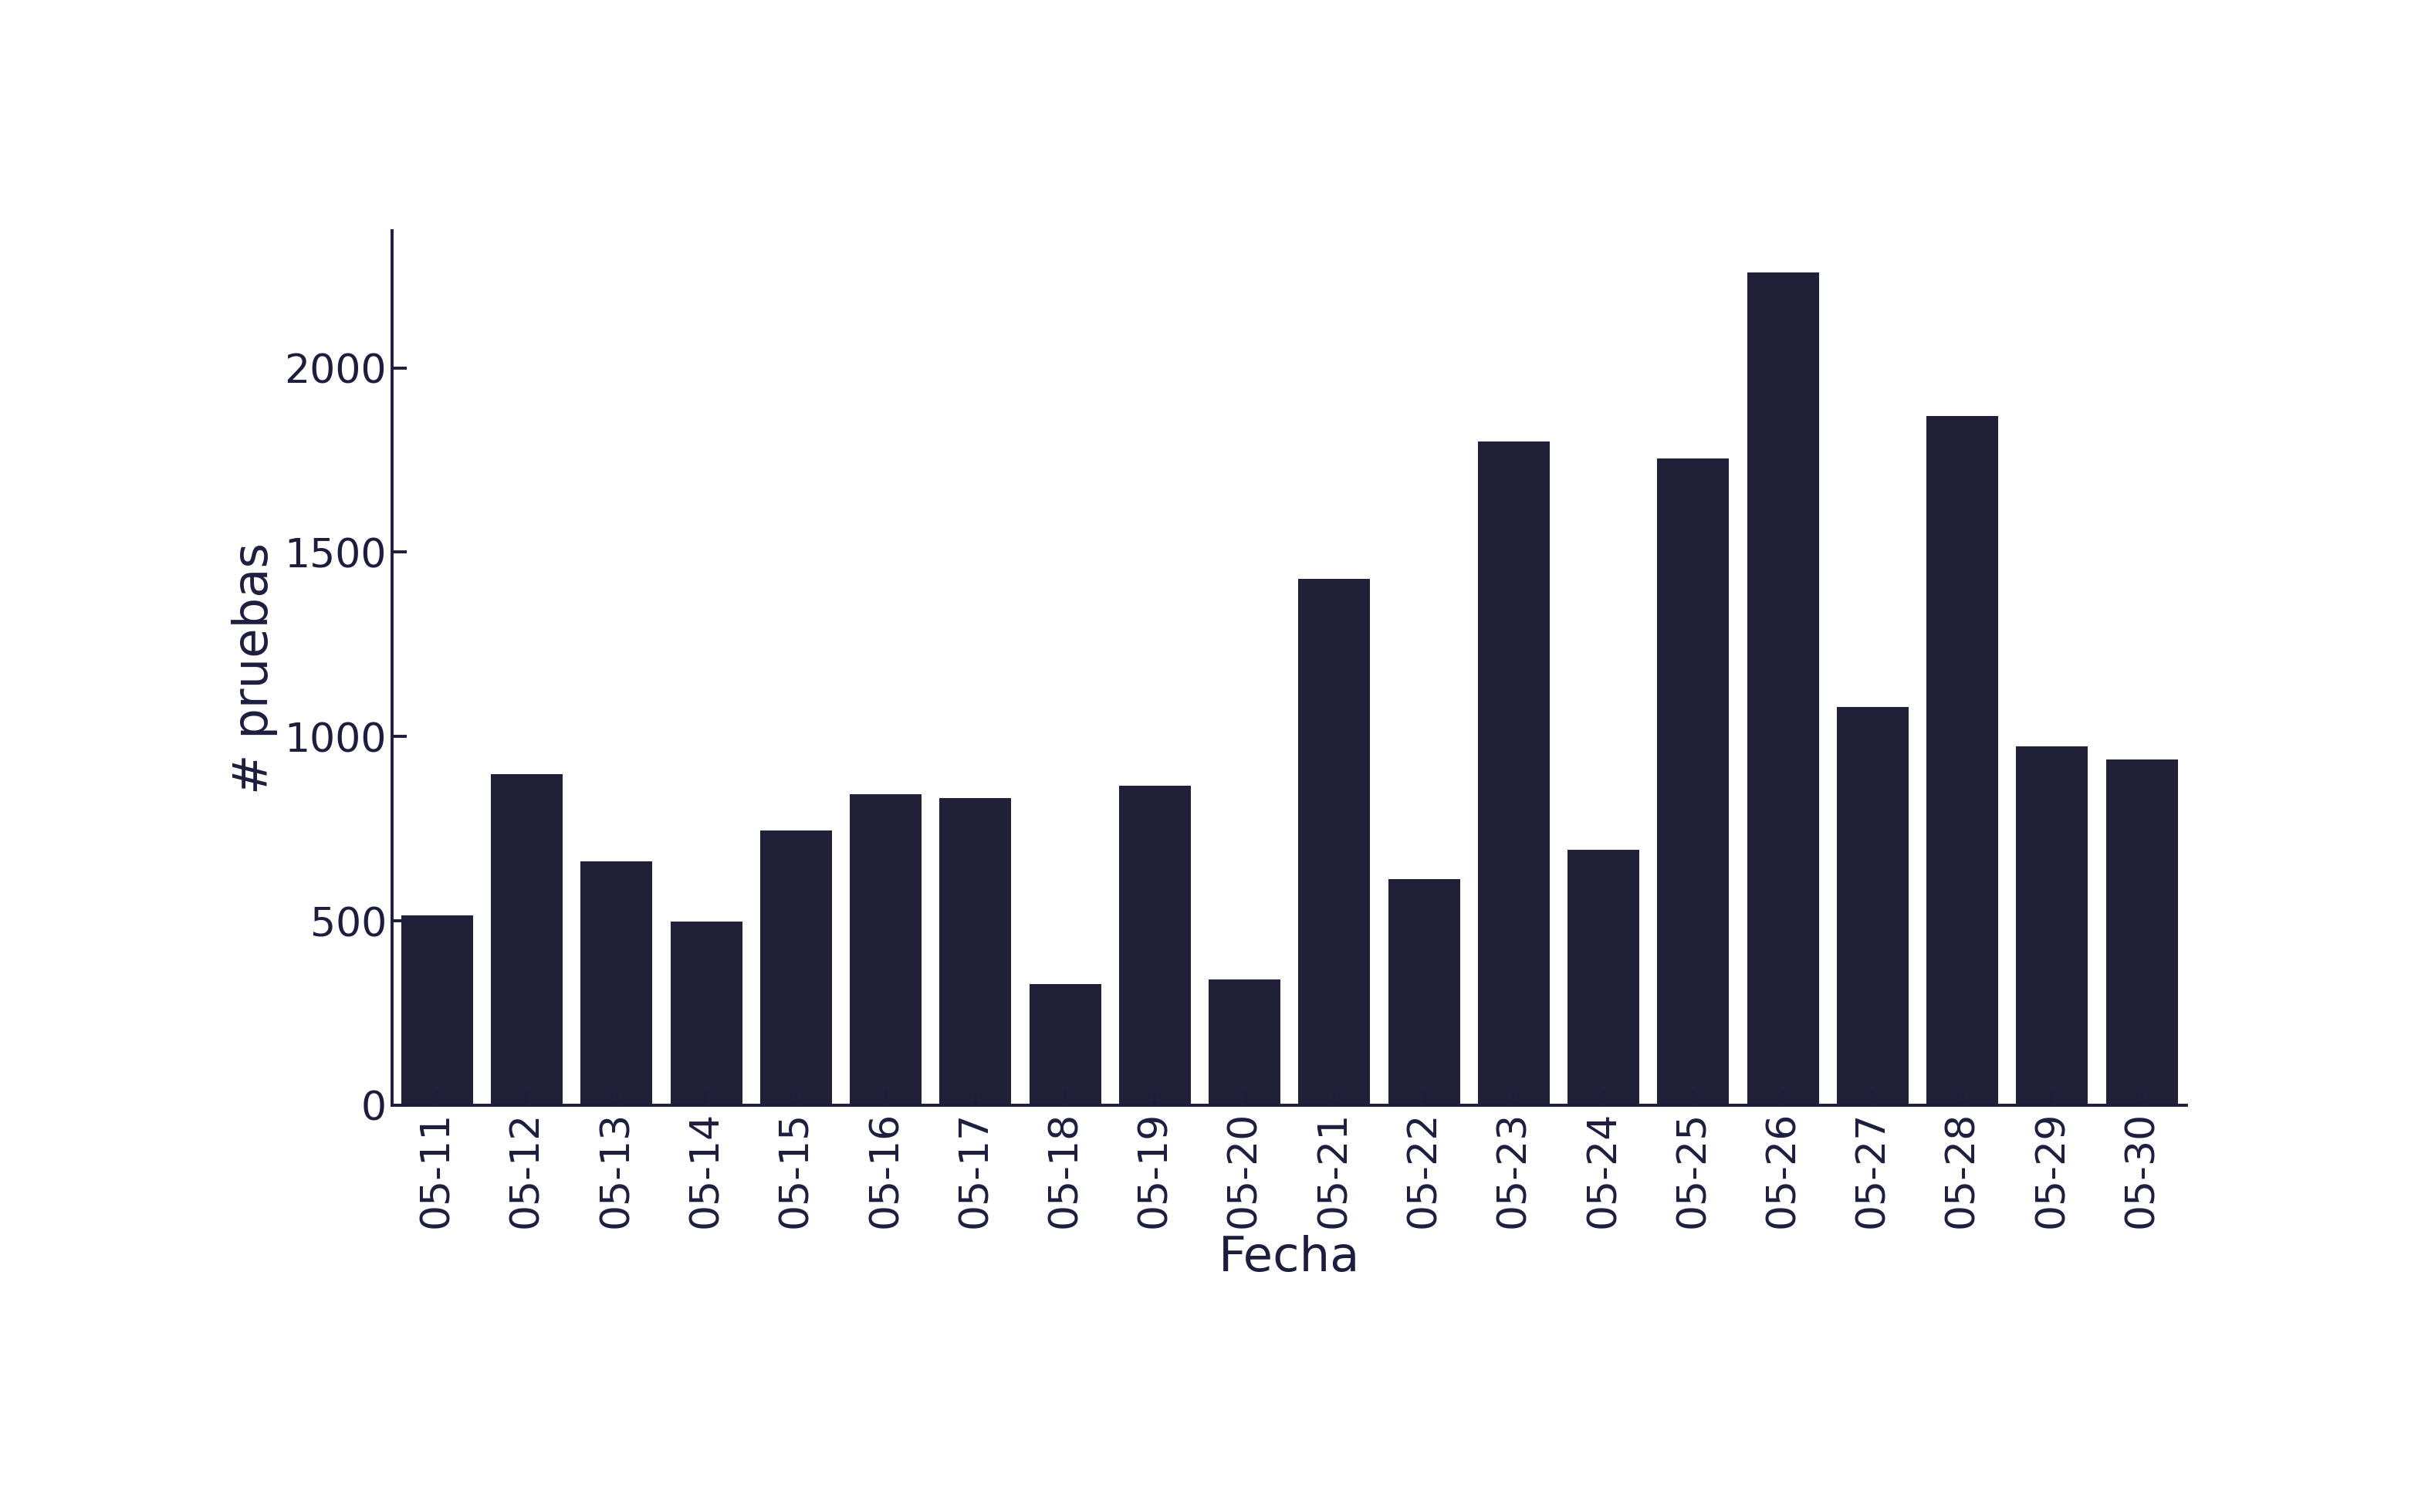

In [21]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha", y="cuenta", data=df_muestras_ant[1:], color="#1c1c3c")
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("# pruebas", fontsize=30)
plt.savefig(f'muestras_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Recuperados

In [22]:
df_ant_changed = df_ant.copy()
df_ant_changed["fecha_recuperado"] = df_ant_changed["fecha_recuperado"].dropna()
cuenta_rec = pd.DataFrame(df_ant_changed.groupby("fecha_recuperado")["id_de_caso"].count()).reset_index()

cuenta_rec = cuenta_rec.rename(columns={"id_de_caso":"cuenta"})

idx = pd.date_range(cuenta_rec["fecha_recuperado"].min(), cuenta_rec["fecha_recuperado"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta_rec = all_dates.merge(cuenta_rec, left_on="fecha", 
                right_on="fecha_recuperado", 
                how="left").drop("fecha_recuperado", axis=1).fillna(0)
cuenta_rec["fecha"] = cuenta_rec["fecha"].dt.strftime('%m-%d')
cuenta_rec.tail()

,fecha,cuenta
70,05-24,11.0
71,05-25,12.0
72,05-26,4.0
73,05-27,3.0
74,05-28,4.0


In [23]:
cuenta_rec["cuenta"].sum()

401.0

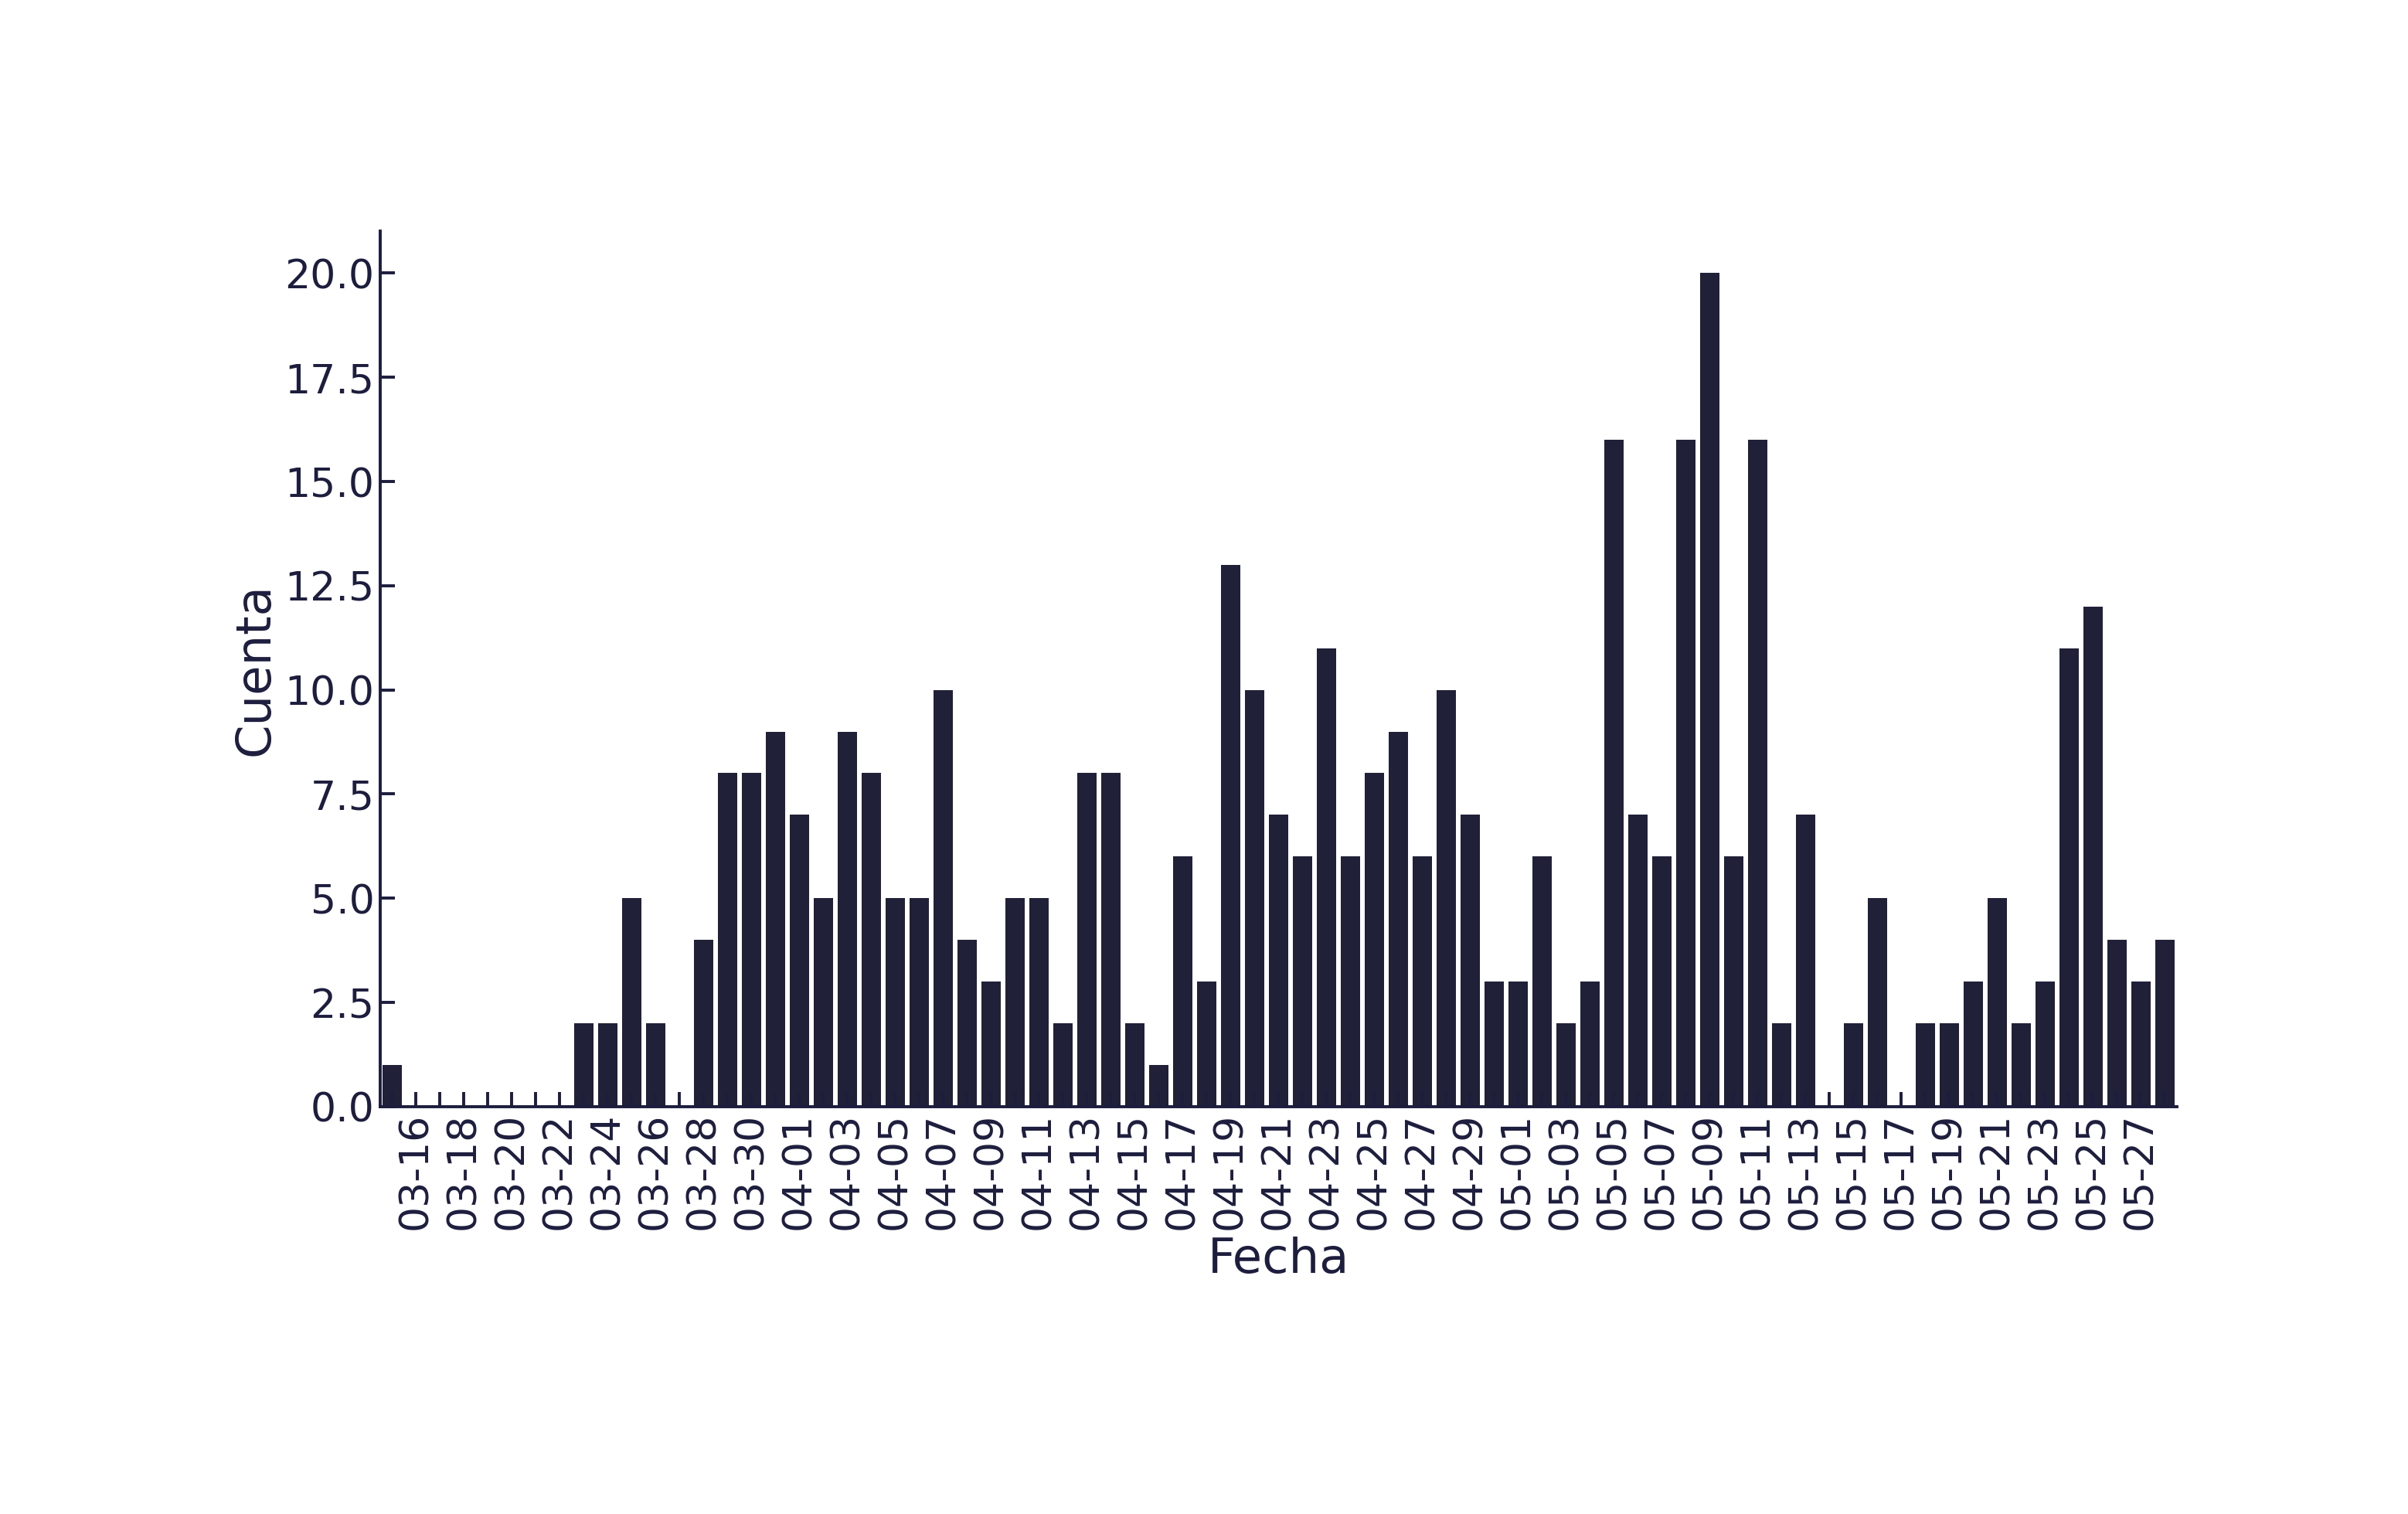

In [24]:
sns.set_context("talk")
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta_rec, color="#1c1c3c")
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("Cuenta", fontsize=30)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f'recuperados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [25]:
df_ant[df_ant["estado"] == "FALLECIDO"]

,id_de_caso,Fecha de notificacion,codigo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_de_muerte,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tiempo recuperacion,tiempo muerte
676,677,2020-03-28T00:00:00.000,5652,San Francisco,Antioquia,FALLECIDO,80,M,EN ESTUDIO,FALLECIDO,Colombia,2020-03-22,2020-04-24,2020-03-29,NaT,2020-03-29T00:00:00.000,NaN,33.0
1513,1514,2020-04-03T00:00:00.000,5001,Medellín,Antioquia,FALLECIDO,91,F,RELACIONADO,FALLECIDO,Colombia,2020-03-20,2020-04-03,2020-04-06,NaT,2020-04-06T00:00:00.000,NaN,14.0
3152,3153,2020-04-09T00:00:00.000,5001,Medellín,Antioquia,FALLECIDO,67,M,RELACIONADO,FALLECIDO,Colombia,2020-04-01,2020-04-18,2020-04-16,NaT,2020-04-16T00:00:00.000,NaN,17.0
3292,3293,2020-04-16T00:00:00.000,5313,Granada,Antioquia,FALLECIDO,87,F,EN ESTUDIO,FALLECIDO,Colombia,2020-04-06,2020-05-02,2020-04-17,NaT,2020-04-17T00:00:00.000,NaN,26.0
3634,3635,2020-04-16T00:00:00.000,5001,Medellín,Antioquia,FALLECIDO,74,M,RELACIONADO,FALLECIDO,Colombia,2020-04-14,2020-04-27,2020-04-19,NaT,2020-04-19T00:00:00.000,NaN,13.0
3641,3642,2020-04-15T00:00:00.000,5088,Bello,Antioquia,FALLECIDO,88,F,RELACIONADO,FALLECIDO,Colombia,2020-04-12,2020-04-18,2020-04-19,NaT,2020-04-19T00:00:00.000,NaN,6.0


In [26]:
df_ant["estado"].value_counts()

LEVE            769
ASINTOMATICO    263
MODERADO         15
FALLECIDO         6
GRAVE             5
Name: estado, dtype: int64

In [27]:
df_male = df_ant[df_ant["sexo"] == "M"]
df_female = df_ant[df_ant["sexo"] == "F"]

male_death = df_male[df_male["estado"]=="FALLECIDO"]
female_death = df_female[df_female["estado"]=="FALLECIDO"]

m_cont = df_male.groupby(pd.cut(df_male["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Hombres")
f_cont = df_female.groupby(pd.cut(df_female["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Mujeres")

piramide = m_cont.join(f_cont).reset_index()

piramide["Hombres"] = -piramide["Hombres"]

piramide.head()

,edad,Hombres,Mujeres
0,"(0, 4]",-6,7
1,"(4, 8]",-6,7
2,"(8, 12]",-9,10
3,"(12, 16]",-7,9
4,"(16, 20]",-23,26


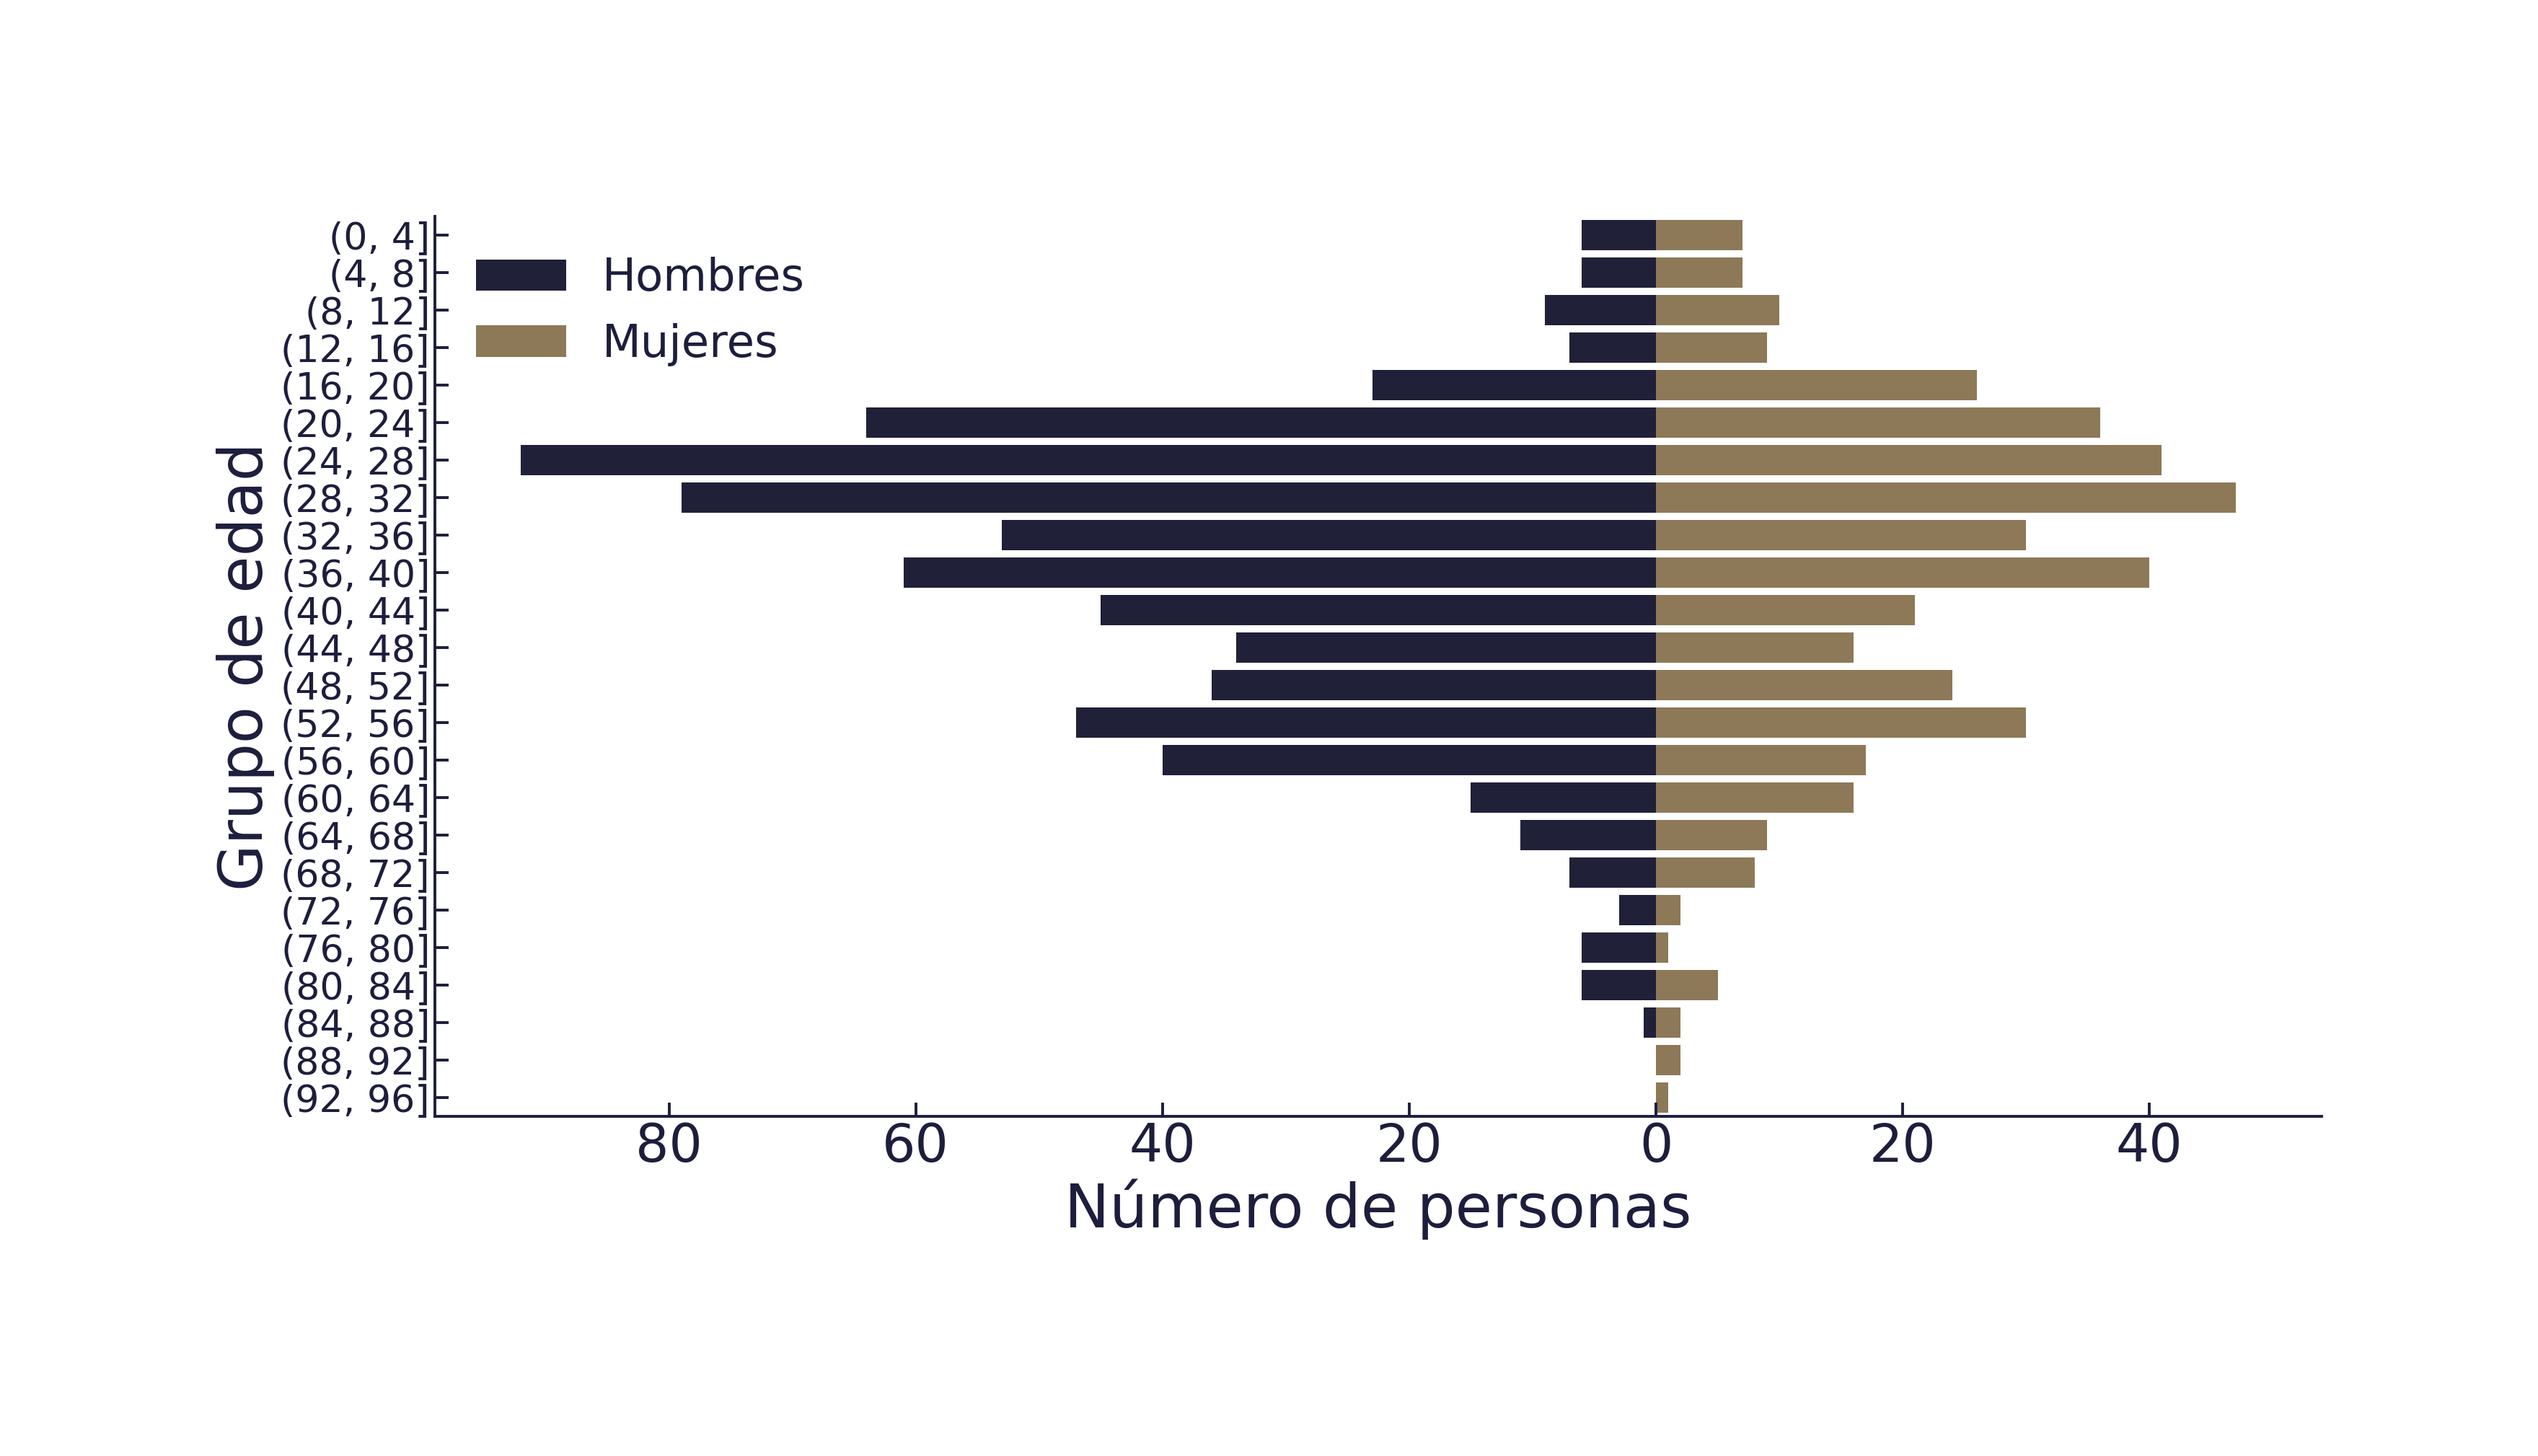

In [28]:
# sns.set_color_codes("pastel")
plt.figure(figsize=(20,10))
bar_plot = sns.barplot(x="Hombres",y="edad", color="#1c1c3c", label="Hombres",data = piramide)

bar_plot = sns.barplot(x="Mujeres",y="edad", color="#967B4F", label="Mujeres",data = piramide)


plt.ylabel('Grupo de edad',size=40)
plt.xlabel('Número de personas',size=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=25)

bar_plot.set_xticklabels(np.abs(list(bar_plot.get_xticks())).astype(int))
plt.legend(framealpha=0.0, fontsize=30)

plt.tight_layout()
plt.savefig(f'piramide.png',bbox_inches='tight', transparent="True", pad_inches = 0)

plt.show()

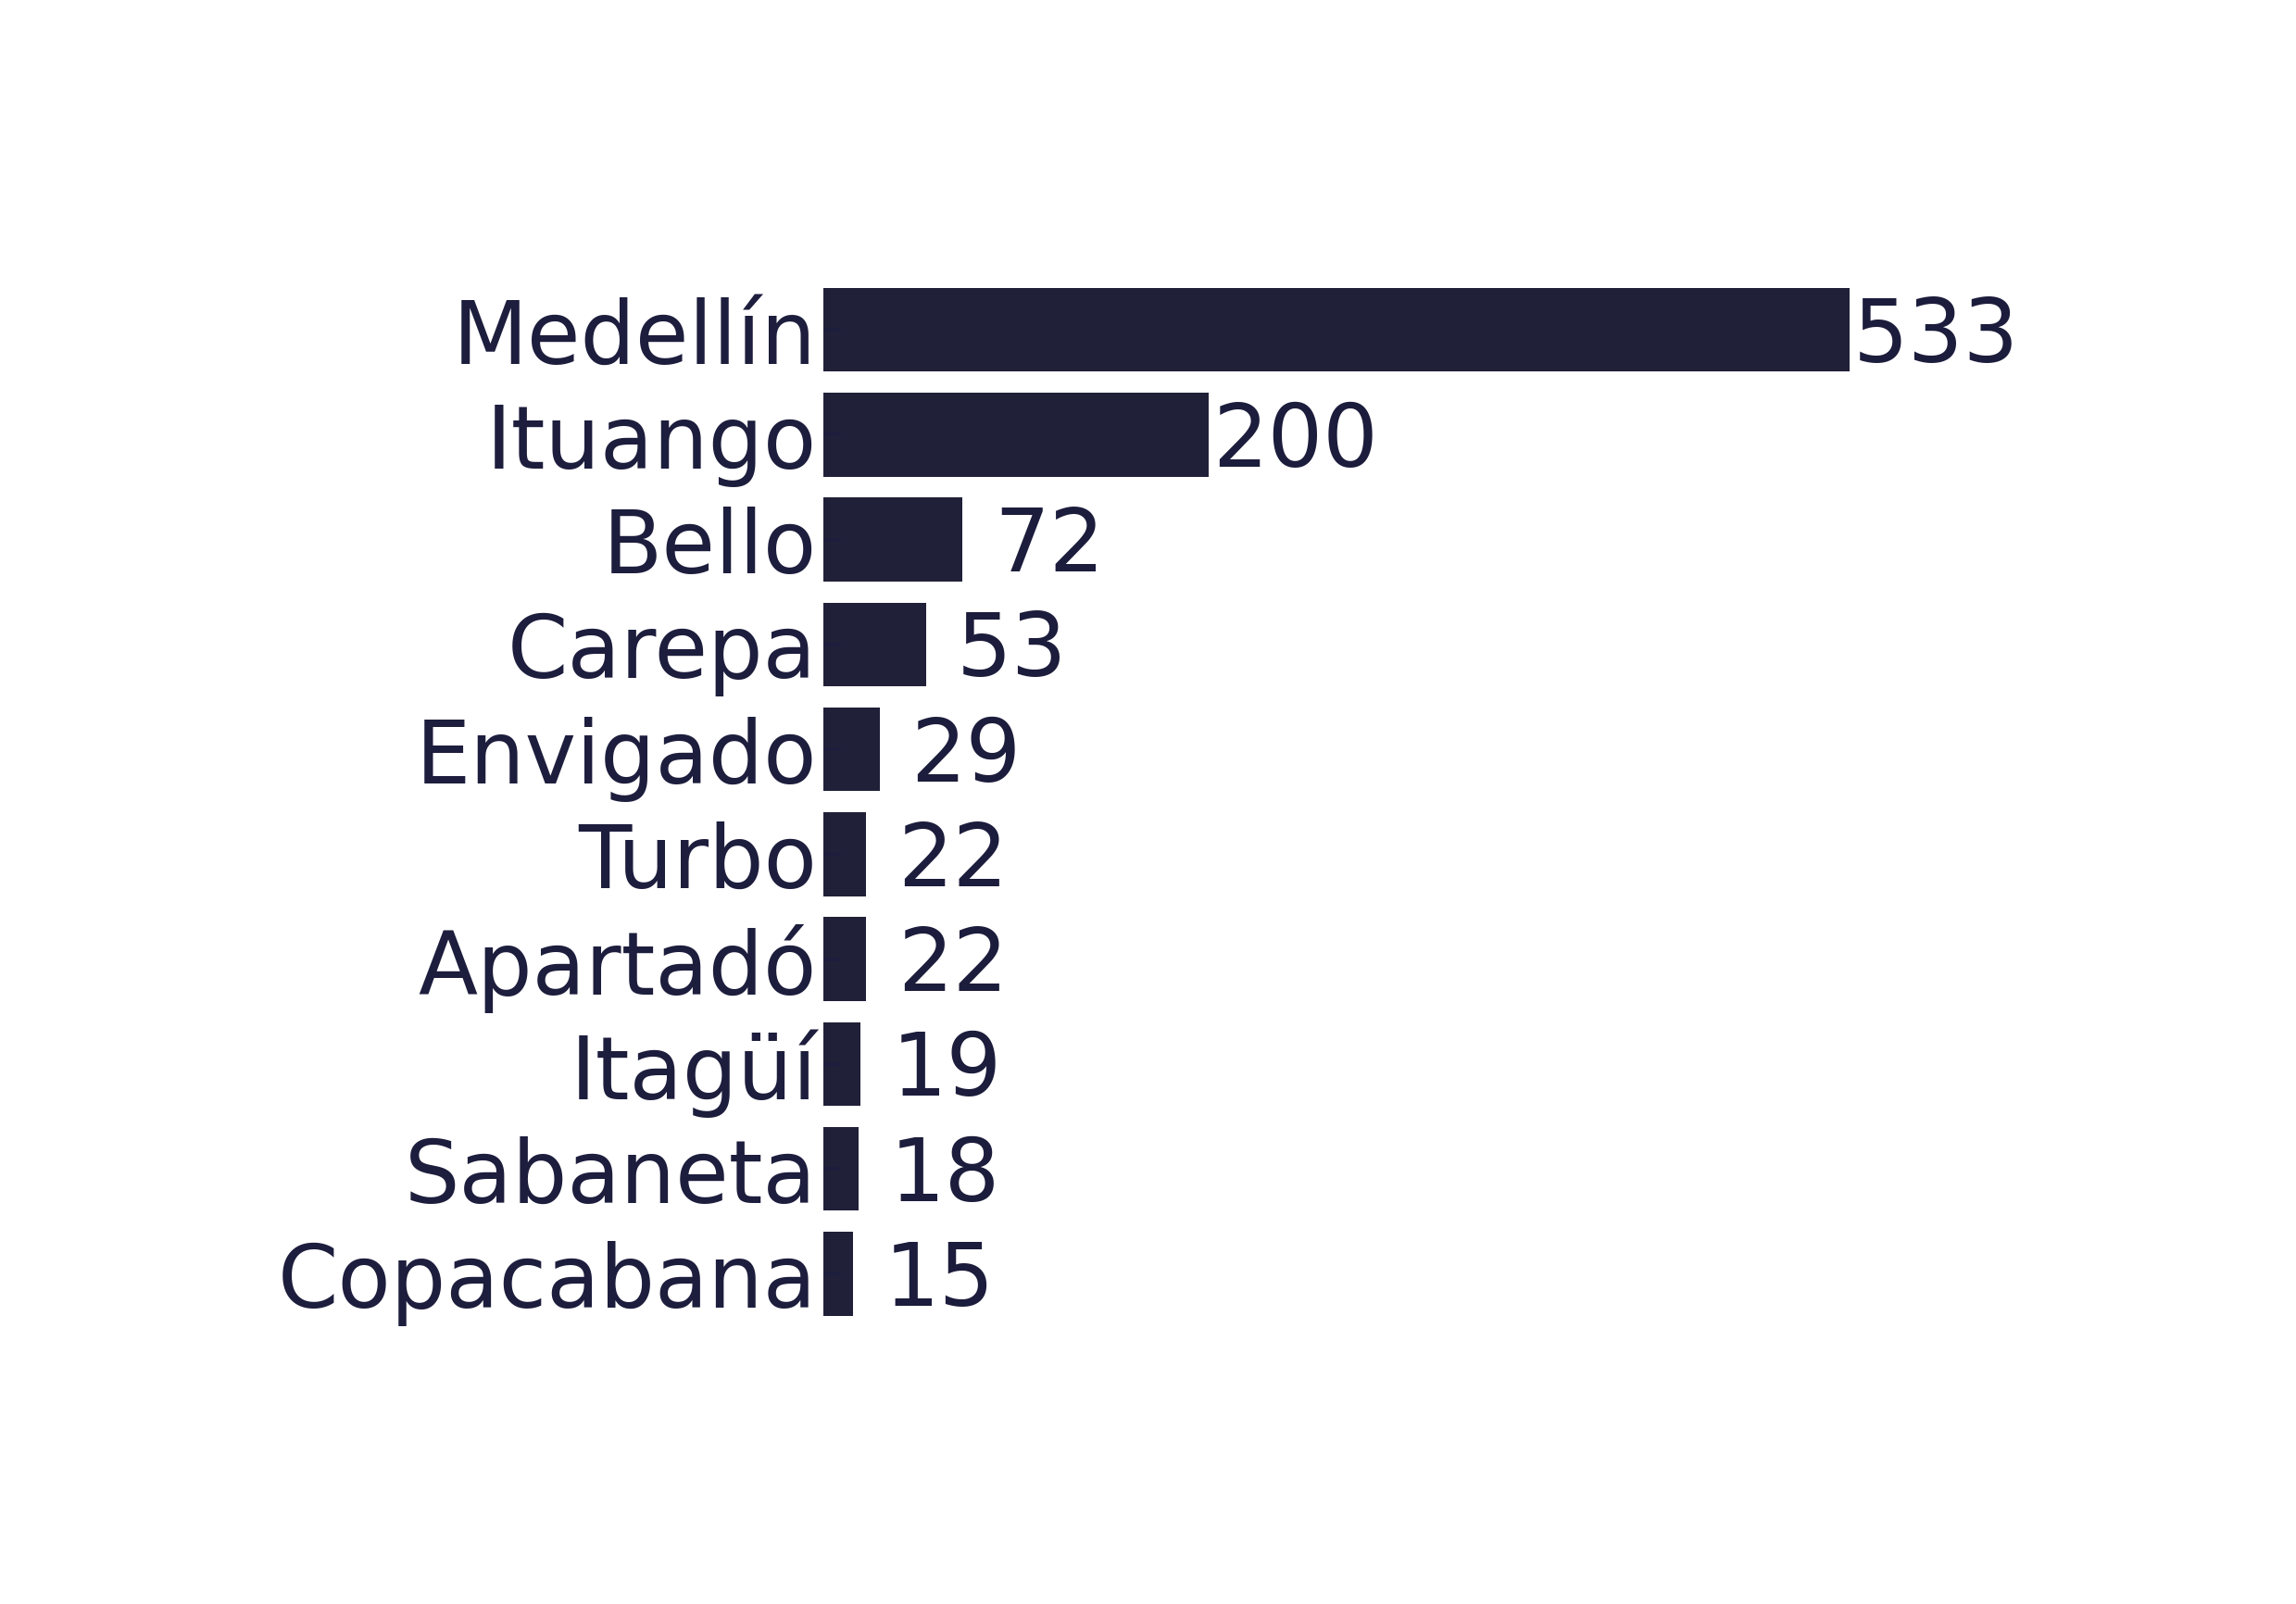

In [30]:
ciudades = df_ant.groupby("ciudad")["id_de_caso"].count().to_frame("cuenta").reset_index()
ciudades = ciudades.sort_values("cuenta", ascending=False).reset_index()
ax = sns.barplot(x = "cuenta", y="ciudad", data=ciudades.head(10), orient="h", color="#1c1c3c")

plt.grid(False)

ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)



# jugar con estos valores
vertical_offset = 0.3
horizontal_offset = 45

ax.tick_params(axis='both', which='major', labelsize=45)
for index, row in ciudades.head(10).iterrows():
    ax.text(row["cuenta"] + horizontal_offset,index+vertical_offset, # posicion
            row["cuenta"], # texto
            color='#1c1c3c', 
            ha="center", 
            size=45)
    
plt.savefig(f'ciudades_antioquia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [31]:
367+296+6+4+4

677

In [32]:
df_ant["atencion"].value_counts()

CASA            583
RECUPERADO      450
HOSPITAL         14
FALLECIDO         6
HOSPITAL UCI      5
N/A               1
Name: atencion, dtype: int64

In [33]:
df_ant["estado"].value_counts()

LEVE            769
ASINTOMATICO    263
MODERADO         15
FALLECIDO         6
GRAVE             5
Name: estado, dtype: int64

In [34]:
df_ant

,id_de_caso,Fecha de notificacion,codigo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_de_muerte,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tiempo recuperacion,tiempo muerte
2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,50,F,IMPORTADO,LEVE,España,2020-02-29,NaT,2020-03-09,2020-03-15,2020-03-09T00:00:00.000,15.0,NaN
3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,55,M,RELACIONADO,LEVE,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,20.0,NaN
4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,25,M,RELACIONADO,LEVE,Colombia,2020-03-08,NaT,2020-03-11,2020-03-23,2020-03-11T00:00:00.000,15.0,NaN
5,6,2020-03-10T00:00:00.000,5360,Itagüí,Antioquia,RECUPERADO,27,F,RELACIONADO,LEVE,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,20.0,NaN
19,20,2020-03-11T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,26,F,RELACIONADO,LEVE,Colombia,2020-03-09,NaT,2020-03-14,2020-03-24,2020-03-14T00:00:00.000,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28058,28099,2020-05-28T00:00:00.000,5088,Bello,Antioquia,CASA,20,M,EN ESTUDIO,LEVE,Colombia,2020-05-25,NaT,2020-05-30,NaT,2020-05-30T00:00:00.000,NaN,NaN
28059,28100,2020-05-27T00:00:00.000,5001,Medellín,Antioquia,CASA,29,F,EN ESTUDIO,LEVE,Colombia,2020-05-24,NaT,2020-05-30,NaT,2020-05-30T00:00:00.000,NaN,NaN
28060,28101,2020-05-26T00:00:00.000,5088,Bello,Antioquia,CASA,25,F,EN ESTUDIO,LEVE,Colombia,2020-05-18,NaT,2020-05-30,NaT,2020-05-30T00:00:00.000,NaN,NaN
28061,28102,2020-05-26T00:00:00.000,5001,Medellín,Antioquia,CASA,34,M,RELACIONADO,LEVE,Colombia,2020-05-23,NaT,2020-05-30,NaT,2020-05-30T00:00:00.000,NaN,NaN
